In [1]:
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import pandas as pd
import matplotlib

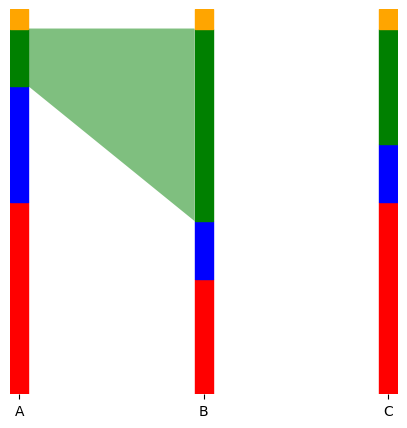

In [2]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.xaxis.set_major_locator(FixedLocator([0, 1, 2]))
ax.set_xlim([0 - 0.05, 2 + 0.05])
ax.set_xticklabels(["A", "B", "C"])

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_yticks([])

sizes = [[0.5, 0.3, 0.15, 0.05], [0.3, 0.15, 0.5, 0.05], [0.5, 0.15, 0.3, 0.05]]
colors = ["red", "blue", "green", "orange"]
for index, size in enumerate(sizes):
    for a_index, a_size in enumerate(size):
        rect = Rectangle(
            xy=(index - 0.05, sum(size[:a_index])), width=0.1, height=a_size, color=colors[a_index], zorder=1
        )
        ax.add_patch(rect)


poly = PathPatch(
    Path(
        vertices=[
            (0.05, 0.8),
            (0.95, 0.45),
            (0.95, 0.95),
            (0.05, 0.95),
        ],
        codes=[Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO],
        closed=True,
    ),
    color="green",
    zorder=0,
    alpha=0.5,
    lw=0,
)
ax.add_patch(poly)

In [42]:
from matplotlib.axes import Axes

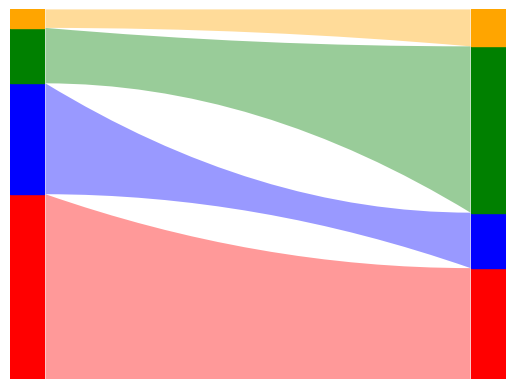

In [107]:
SIZES = [[0.5, 0.3, 0.15, 0.05], [0.3, 0.15, 0.45, 0.1]]
COLORS = ["red", "blue", "green", "orange"]
FRAMEON = True

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, width_ratios=[1, 12, 1], frameon=FRAMEON)

# Remove spacing
fig.subplots_adjust(hspace=0, wspace=0)


def _clean_axis(_ax: Axes, frameon: bool = True) -> Axes:
    _ax.set_yticklabels([])
    _ax.set_xticklabels([])
    _ax.set_ylim(0, 1)
    _ax.set_yticks([])
    _ax.set_xticks([])

    if frameon is False:
        # Despine
        _ax.spines["top"].set_visible(False)
        _ax.spines["left"].set_visible(False)
        _ax.spines["right"].set_visible(False)
        _ax.spines["bottom"].set_visible(False)
    return _ax


ax0 = _clean_axis(ax0, frameon=False)

for index, size in enumerate(SIZES[0]):
    rect = Rectangle(xy=(0, sum(SIZES[0][:index])), width=1, height=size, color=COLORS[index], zorder=1)
    ax0.add_patch(rect)

ax1 = _clean_axis(ax1, frameon=False)


for index in range(len(COLORS)):
    y1_start = sum(SIZES[0][:index])
    y1_end = sum(SIZES[1][:index])

    y2_start = sum(SIZES[1][: index + 1])
    y2_end = sum(SIZES[0][: index + 1])

    # Add curves
    poly = PathPatch(
        Path(
            vertices=[
                (0.0, y1_start),
                (0.5, (y1_start - y1_end) + y1_end),
                (1, y1_end),
                (1, y2_start),
                (0.5, (y2_start - y2_end) + y2_end),
                (0, y2_end),
            ],
            codes=[Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.CURVE3],
            closed=True,
        ),
        color=COLORS[index],
        zorder=0,
        alpha=0.4,
        lw=0,
    )
    ax1.add_patch(poly)

ax2 = _clean_axis(ax2, frameon=False)

for index, size in enumerate(SIZES[1]):
    rect = Rectangle(xy=(0, sum(SIZES[1][:index])), width=1, height=size, color=COLORS[index], zorder=1)
    ax2.add_patch(rect)

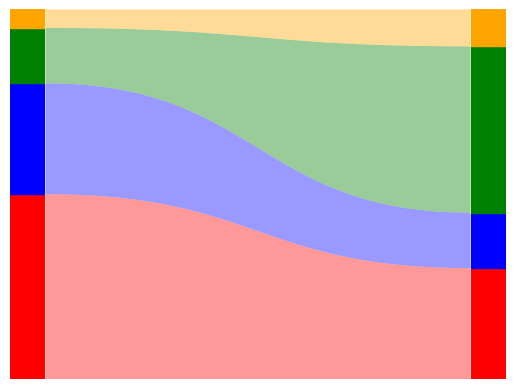

In [112]:
SIZES = [[0.5, 0.3, 0.15, 0.05], [0.3, 0.15, 0.45, 0.1]]
COLORS = ["red", "blue", "green", "orange"]
FRAMEON = True

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, width_ratios=[1, 12, 1], frameon=FRAMEON)

# Remove spacing
fig.subplots_adjust(hspace=0, wspace=0)


def _clean_axis(_ax: Axes, frameon: bool = True) -> Axes:
    _ax.set_yticklabels([])
    _ax.set_xticklabels([])
    _ax.set_ylim(0, 1)
    _ax.set_yticks([])
    _ax.set_xticks([])

    if frameon is False:
        # Despine
        _ax.spines["top"].set_visible(False)
        _ax.spines["left"].set_visible(False)
        _ax.spines["right"].set_visible(False)
        _ax.spines["bottom"].set_visible(False)
    return _ax


ax0 = _clean_axis(ax0, frameon=False)

for index, size in enumerate(SIZES[0]):
    rect = Rectangle(xy=(0, sum(SIZES[0][:index])), width=1, height=size, color=COLORS[index], zorder=1)
    ax0.add_patch(rect)

ax1 = _clean_axis(ax1, frameon=False)


for index in range(len(COLORS)):
    y1_start = sum(SIZES[0][:index])
    y1_end = sum(SIZES[1][:index])

    y2_start = sum(SIZES[1][: index + 1])
    y2_end = sum(SIZES[0][: index + 1])

    # Add curves
    poly = PathPatch(
        Path(
            vertices=[
                (0.0, y1_start),
                (0.5, y1_start),
                (0.5, y1_end),
                (1, y1_end),
                (1, y2_start),
                (0.5, y2_start),
                (0.5, y2_end),
                (0, y2_end),
            ],
            codes=[
                Path.MOVETO,
                Path.CURVE4,
                Path.CURVE4,
                Path.CURVE4,
                Path.LINETO,
                Path.CURVE4,
                Path.CURVE4,
                Path.CURVE4,
            ],
            closed=True,
        ),
        color=COLORS[index],
        zorder=0,
        alpha=0.4,
        lw=0,
    )
    ax1.add_patch(poly)

ax2 = _clean_axis(ax2, frameon=False)

for index, size in enumerate(SIZES[1]):
    rect = Rectangle(xy=(0, sum(SIZES[1][:index])), width=1, height=size, color=COLORS[index], zorder=1)
    ax2.add_patch(rect)